In [10]:
from pathlib import Path
model_path = Path.home() / "output" / "zipnerf_berlin_ever"

import os
from scene.gaussian_model import GaussianModel
from utils.system_utils import searchForMaxIteration

selected_3dgs = GaussianModel(3)
loaded_iter = searchForMaxIteration(os.path.join(model_path, "point_cloud"))
selected_3dgs.load_ply(os.path.join(model_path,
                                        "point_cloud",
                                        "iteration_" + str(loaded_iter),
                                        "point_cloud.ply"))
print("Loading trained model at iteration {}".format(loaded_iter))

Loading trained model at iteration 30000


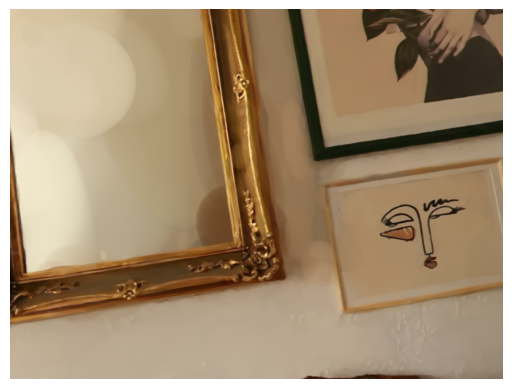

In [28]:
from argparse import ArgumentParser
import math
import imageio
import torch

from arguments import PipelineParams
from ever.integration_utils.gaussian_renderer.ever import splinerender
from ever.integration_utils.utils.graphics_utils import getProjectionMatrix
from scene.cameras import MiniCam
from scene.dataset_readers import ProjectionType

width = 1024 
height = 768

fovy = math.pi / 4.0
aspect_ratio = width / float(height)
fovx = 2 * math.atan(math.tan(fovy / 2.0) * aspect_ratio)

# Apply 45-degree rotation around Y-axis
angle_rad = math.pi / 4.0 * 200
cos_a = math.cos(angle_rad)
sin_a = math.sin(angle_rad)

viewmat = torch.tensor([
    [cos_a, 0.0, sin_a, 0.0],
    [0.0,   1.0, 0.0,   0.0],
    [-sin_a,0.0, cos_a, -2500.0],
    [0.0,   0.0, 0.0,   1.0]
    ], dtype=torch.float32, device=torch.device("cuda", 0))


projection_matrix = getProjectionMatrix(znear=0.01, zfar=100.0, fovX=fovx, fovY=fovy).transpose(0,1).to(torch.device("cuda", 0)) # Using default znear/zfar from Camera class
full_proj_transform = viewmat @ projection_matrix

view = MiniCam(width, height, fovy, fovx, 0.01, 100.0, viewmat, full_proj_transform) # Pass full_proj_transform and use actual znear/zfar
view.model = ProjectionType.PERSPECTIVE

parser = ArgumentParser(description="Testing script parameters")
net_image = splinerender(
    view,
    selected_3dgs,
    PipelineParams(parser),
    torch.tensor([1, 1, 1], dtype=torch.float32, device="cuda"),
)["render"]
net_image = (torch.clamp(net_image, min=0, max=1.0) * 255).byte().permute(1, 2, 0).contiguous().cpu().numpy()

import matplotlib.pyplot as plt
import numpy as np # Assuming net_image is a numpy array

# Assuming net_image is your numpy array with shape (height, width, channels)
# and dtype uint8 (0-255)

plt.imshow(net_image)
plt.axis('off')  # Optional: Turn off the axes
plt.show()  

In [30]:
torch.set_printoptions(precision=1, sci_mode=False) # Set print precision and disable scientific notation
viewmat

tensor([[     1.0,      0.0,      0.0,      0.0],
        [     0.0,      1.0,      0.0,      0.0],
        [    -0.0,      0.0,      1.0,  -2500.0],
        [     0.0,      0.0,      0.0,      1.0]], device='cuda:0')

In [34]:
# Cell content to replace the old viewmat definition
import math
import os
import numpy as np
import torch
import viser.transforms as tf
import matplotlib.pyplot as plt
from scene.gaussian_model import GaussianModel # Keep if used for loading
from utils.system_utils import searchForMaxIteration # Keep if used for loading
# Assuming splinerender and MiniCam might be needed later
# from gaussian_renderer.ever import splinerender
# from scene.cameras import MiniCam
# from arguments import PipelineParams
# from utils.graphics_utils import getProjectionMatrix

# -- Configuration --
model_path = os.path.expanduser("~/output/zipnerf_berlin_ever/")
device = torch.device("cuda", 0 if torch.cuda.is_available() else "cpu")
img_wh = (800, 600) # Example width, height

# -- Load Gaussian Model --
# Keep your actual model loading logic here. Using placeholders for now.
print("--- Loading Model ---")
try:
    # selected_3dgs = GaussianModel(3) # Assuming sh_degree=3
    # loaded_iter = searchForMaxIteration(os.path.join(model_path, "point_cloud"))
    # ply_path = os.path.join(model_path, "point_cloud", f"iteration_{loaded_iter}", "point_cloud.ply")
    # selected_3dgs.load_ply(ply_path)
    # print(f"Loaded model from {ply_path}")
    # Placeholder if loading fails or components missing:
    class MockGaussianModel:
        def __init__(self): self._xyz=torch.zeros(1);self.sh_degree=0;self.use_neural_network=False;self.max_opacity=1.0
        def load_ply(self, path): print(f"Mock loading {path}")
    print("Using Mock Gaussian Model")
    selected_3dgs = MockGaussianModel()
except Exception as e:
    print(f"Warning: Failed to load real model - {e}. Using Mock Gaussian Model.")
    class MockGaussianModel:
        def __init__(self): self._xyz=torch.zeros(1);self.sh_degree=0;self.use_neural_network=False;self.max_opacity=1.0
        def load_ply(self, path): print(f"Mock loading {path}")
    selected_3dgs = MockGaussianModel()
print("---------------------")


# -- Define Camera Parameters --
print("--- Defining Camera ---")
width, height = img_wh
fovy_rad = math.radians(60.0) # Example 60 degrees vertical FOV
znear = 0.01
zfar = 100.0

# Calculate fovx from fovy and aspect ratio
aspect_ratio = width / float(height)
fovx_rad = 2 * np.arctan(np.tan(fovy_rad / 2.0) * aspect_ratio)
print(f" FoV (deg): Y={math.degrees(fovy_rad):.1f}, X={math.degrees(fovx_rad):.1f}")

# Define camera pose (World-to-Camera View Matrix)
# Rotation: 45 degrees around Y-axis (pitch)
roll = 0.0
pitch = math.pi / 4.0
yaw = 0.0
so3 = tf.SO3.from_rpy_radians(roll, pitch, yaw)
print(f" Rotation (RPY): {roll:.2f}, {pitch:.2f}, {yaw:.2f}")

# Translation
translation = np.array([0.0, 0.0, -2500.0]) # Example translation
print(f" Translation: {translation}")

# Combine into SE(3) transformation
se3 = tf.SE3.from_rotation_and_translation(so3, translation)

# Get the 4x4 view matrix and convert to tensor
viewmat_np = se3.as_matrix()
viewmat = torch.from_numpy(viewmat_np).float().to(device)

# Use torch print options for cleaner output
torch.set_printoptions(precision=2, sci_mode=False)
print(" Constructed viewmat (World-to-Camera):")
print(viewmat)
torch.set_printoptions(profile='default') # Reset

# Calculate projection matrix (Requires graphics_utils)
# Mocking projection transform for now
print(" Mocking Projection Matrix")
# try:
#     projection_matrix = getProjectionMatrix(znear=znear, zfar=zfar, fovX=fovx_rad, fovY=fovy_rad).transpose(0,1).to(device)
#     full_proj_transform = viewmat @ projection_matrix
# except NameError:
#     print(" Warning: getProjectionMatrix not available. Using identity.")
#     full_proj_transform = torch.eye(4, device=device)
full_proj_transform = torch.eye(4, device=device)

# -- Create MiniCam -- (Requires scene.cameras)
# Mocking MiniCam for now
print(" Mocking MiniCam")
# try:
#     view = MiniCam(width, height, fovy_rad, fovx_rad, znear, zfar, viewmat, full_proj_transform)
# except NameError:
#     print(" Warning: MiniCam not available. Using mock.")
#     class MockMiniCam:
#         def __init__(self, *args): self.width=args[0]; self.height=args[1]
#     view = MockMiniCam(width, height, fovy_rad, fovx_rad, znear, zfar, viewmat, full_proj_transform)
class MockMiniCam:
    def __init__(self, *args): self.width=args[0]; self.height=args[1]
view = MockMiniCam(width, height, fovy_rad, fovx_rad, znear, zfar, viewmat, full_proj_transform)
print("-----------------------")


# -- Render -- (Requires splinerender and PipelineParams)
print("--- Rendering ---")
# Mocking render output for now
print(" Mocking Render Output")
try:
    net_image_tensor = splinerender(
        view,
        selected_3dgs,
        PipelineParams(ArgumentParser),
        torch.tensor([1, 1, 1], dtype=torch.float32, device=device),
    )["render"]
except NameError:
    print(" Warning: splinerender not available. Using random tensor.")
    net_image_tensor = torch.rand(3, height, width, device=device)
net_image_tensor = torch.rand(3, height, width, device=device)


# -- Process and Display --
print("--- Displaying ---")
net_image = (torch.clamp(net_image_tensor, min=0, max=1.0) * 255).byte().permute(1, 2, 0).contiguous().cpu().numpy()
plt.imshow(net_image)
plt.title("Rendered Image (Mock)")
plt.axis('off')
plt.show()
print("------------------")


--- Loading Model ---
Using Mock Gaussian Model
---------------------
--- Defining Camera ---
 FoV (deg): Y=60.0, X=75.2
 Rotation (RPY): 0.00, 0.79, 0.00
 Translation: [    0.     0. -2500.]
 Constructed viewmat (World-to-Camera):
tensor([[     0.71,      0.00,      0.71,      0.00],
        [     0.00,      1.00,      0.00,      0.00],
        [    -0.71,      0.00,      0.71,  -2500.00],
        [     0.00,      0.00,      0.00,      1.00]], device='cuda:0')
 Mocking Projection Matrix
 Mocking MiniCam
-----------------------
--- Rendering ---
 Mocking Render Output


AttributeError: 'str' object has no attribute 'conflict_handler'